<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-2/blob/main/Assignment/0926-Handson-ch07-Ensemble-%26-Random-Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 7. 앙상블 학습과 랜덤 포레스트**

## **7.1 투표 기반 분류기**

- 더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것임.
- **직접 투표** 분류기: 다수결 투표로 정해지는 분류기
    - 각 분류기가 약한 학습기(즉, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는) 강한 학습기가 될 수 있음.
- 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키기

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

- 각 분류기의 테스트셋 정확도 확인

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.904


&rarr; 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음.

- 간접 투표: 모든 분류기가 클래스의 확률을 예측할 수 있으면(즉, `predict_proba()` 메서드가 있으면), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있는 방식
    - `voting="hard"`를 `voting="soft"`로 바꾸 고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨
    - SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 `probability` 매개변수를 `True`로 지정해야 함

## **7.2 배깅과 페이스팅**

- **배깅**: 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- **페이스팅**: 훈련 세트에서 중복을 허용하지 않고 샘플링하는 방식
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦.
    - 수집 함수는 전형적으로 분류일 때는 통계적 최빈값(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)이고 회귀에 대해서는 평균을 계산함
    - 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함
    - 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦

### 7.2.1 사이킷런의 배깅과 페이스팅
- 결정 트리 분류기 500개의 앙상블을 훈련시키기

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

&rarr; 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것 같아 보임.

&rarr; 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호함. 그러나 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋음.

### 7.2.2. oob 평가
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음.
- BaggingClassifier는 기본값으로 중복을 허용하여 (`bootstrap=True`) 훈련 세트의 크기만큼인 m개 샘플을 선택함
    - 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미함
    - 선택되지 않은 훈련 샘플의 나머지 37%를 oobout of bag 샘플이라고 부름
    - 예측기마다 남겨진 37%는 모두 다름
- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음.
    - 사이킷런에서 BaggingClassifier를 만들 때 `oob_score=True`로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행함
    - 평가 점수 결과는 oob_ score 변수에 저장되어 있음

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

- oob 샘플에 대한 결정 함수의 값 확인

In [6]:
bag_clf.oob_decision_function_

array([[0.43956044, 0.56043956],
       [0.3583815 , 0.6416185 ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.00571429, 0.99428571],
       [0.07954545, 0.92045455],
       [0.32065217, 0.67934783],
       [0.02702703, 0.97297297],
       [0.99408284, 0.00591716],
       [0.97575758, 0.02424242],
       [0.80213904, 0.19786096],
       [0.01142857, 0.98857143],
       [0.83068783, 0.16931217],
       [0.8404908 , 0.1595092 ],
       [0.96842105, 0.03157895],
       [0.06951872, 0.93048128],
       [0.        , 1.        ],
       [0.99462366, 0.00537634],
       [0.98275862, 0.01724138],
       [0.98314607, 0.01685393],
       [0.01648352, 0.98351648],
       [0.37572254, 0.62427746],
       [0.90217391, 0.09782609],
       [1.        , 0.        ],
       [0.96551724, 0.03448276],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62962963, 0.37037037],
       [0.

## **7.3 랜덤 패치와 랜덤 서브 스페이스**
- BaggingClassifier는 특성 샘플링도 지원함.
    - 샘플링은 `max_features`, `bootstrap_ features` 두 매개변수로 조절됨
    - 특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용함
- **랜덤 패치 방식**: 훈련 특성과 샘플을 모두 샘플링하는 것
- **랜덤 서브스페이스 방식**: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

## **7.4 랜덤 포레스트**
- 랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블임.
    - 전형적으로 `max_samples`를 훈련 세트의 크기로 지정함
- 500개의 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키기

In [7]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함.
- 결국 트리를 더욱 다양하게 만들고 (다시 한번) 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄.
- BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만들어 보기


In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리
- 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브 셋을 만들어 분할에 사용함. 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함.
- **익스트림 랜덤 트리**(엑스트라 트리): 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리
    - 여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 됨
    - 일반적으로 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름

### 7.4.2 특성 중요도
- 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것임.
- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함.
    - 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함.
    - 이 값은 `feature_importances_` 변수에 저장되어 있음.
- iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력하기

In [9]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0961030689365781
sepal width (cm) 0.02374384597371519
petal length (cm) 0.4210926153010735
petal width (cm) 0.45906046978863313


- 랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리함.

## **7.5 부스팅**
- **부스팅**(원래는 가설 부스팅): 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것임.

### 7.5.1 에이다부스트
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것임.
- 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨.

In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [13]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

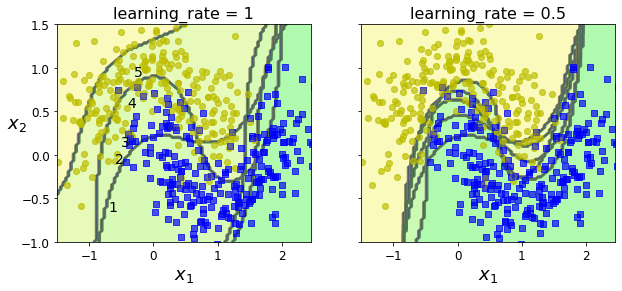

In [16]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

&rarr; moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계

&rarr; 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아짐. 따라서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 됨.

&rarr; 오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것임. 

&rarr; 경사 하강법과 비슷한 면이 있음. 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가함.

- 모든 예측기가 훈련을 마치면 이 앙상블은 배경이나 페이스팅과 비슷한 방식으로 예측을 만듦. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨.
- 에이다부스트 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨.
- 예측을 할 때 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치를 더해 예측 결과를 만듦. 가중치 합이 가장 큰 클래스가 예측 결과가 됨.
- 사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용함.
    - 클래스가 두 개뿐일 때는 SAMME가 에이다부스트와 동일함.
    - 예측기가 클래스의 확률을 추정할 수 있다면 사이킷런은 SAMME.R이라는 SAMME의 변종을 사용함.
    - 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋음.
- 사이킷런의 AdaBoostClassifier를 사용하여 200개의 아주 얕은 결정 트리를 기반으로 하는 에이다부스트 분류기를 훈련시키기

### 7.5.2 그레이디언트 부스팅
- 인기가 높은 또 하나의 부스팅 알고리즘은 **그레이디언트 부스팅**임.
- 에이다부스트처럼 그레이디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함.
- 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴.

*결정 트리를 기반 예측기로 사용하는 간단한 회귀 문제 풀어보기(그레이디언트 트리 부스팅)*
- DecisionTreeRegressor를 훈련 세트에 학습시키기

In [17]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

- 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시키기

In [19]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

- 세 개의 트리를 포함하는 앙상블 모델이 생긴 후, 새로운 샘플에 대한 예측을 만들기 위해 모든 트리의 예측을 더하기

In [20]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [21]:
X_new = np.array([[0.8]])

In [22]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

&rarr; 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있음.

- 사이킷런의 GradientBoostingRegressor를 사용하여 GBRT 앙상블을 간단하게 훈련시키기

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- `learning_rate` 매개변수가 각 트리의 기여 정도를 조절함.
    - 이를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐. 이는 축소라고 부르는 규제 방법임.
- 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있음.
    - 간단하게 구현하려면 `stagged_predict()` 메서드를 사용함
    - 이 메서드는 훈련의 각 단계(트리 하나, 트리 두 개 등)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환함
- 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정하고 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시키기


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=85)

In [25]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [26]:
min_error = np.min(errors)

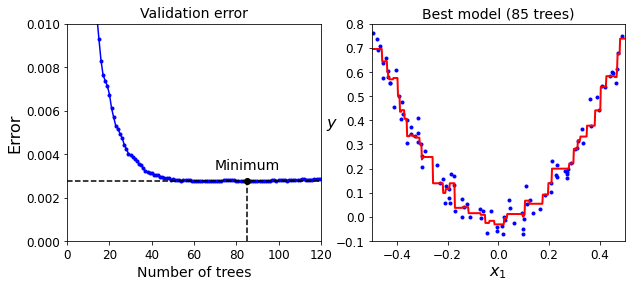

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

- 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수도 있음.
- 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈추기

In [28]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

- GradientBoostingRegressor는 각 트리가 훈련할 대 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원함.
    - 예를 들어 subsample=0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습되는데, 편향이 높아지는 대신 분산이 낮아지게 되며 훈련 속도를 상당히 높임. 이런 기법을 **확률적 그레이디언트 부스팅**이라고 함.
- 최적화된 그레이디언트 부스팅 구현으로 XGBoost 파이썬 라이브러리가 유명함.

In [29]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[07:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[07:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.275313
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.247499
[2]	validation_0-rmse:0.222947
[3]	validation_0-rmse:0.201049
[4]	validation_0-rmse:0.181641
[5]	validation_0-rmse:0.166735
[6]	validation_0-rmse:0.153621
[7]	validation_0-rmse:0.141686
[8]	validation_0-rmse:0.131314
[9]	validation_0-rmse:0.122047
[10]	validation_0-rmse:0.112234
[11]	validation_0-rmse:0.10366
[12]	validation_0-rmse:0.097232
[13]	validation_0-rmse:0.092018
[14]	validation_0-rmse:0.087123
[15]	validation_0-rmse:0.083105
[16]	validation_0-rmse:0.079681
[17]	validation_0-rmse:0.076621
[18]	validation_0-rmse:0.074141
[19]	validation_0-rmse:0.071896
[20]	validation_0-rmse:0.070115
[21]	validation_0-rmse:0.068281
[22]	validation_0-rmse:0.066894
[23]	validation_0-rmse:0.065783
[24]	validation_0-rmse:0.064704
[25]	validation_0-rm

## **7.6 스태킹**
- 스태킹은 '앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 같은)를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까요?'라는 기본 아이디어로 출발함.
- 새로운 샘플에 회귀 작업을 수행하는 앙상블
    - 세 예측기는 각각 다른 값(3.1, 2.7, 2.9)을 예측하고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측을 입력으로 받아 최족 예측(3.0)을 만듦.
- 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것임.
    - 먼저 훈련 세트를 두 개의 서브셋으로 나눔. 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용됨.
    - 그 다음 첫 번째 레이어의 예측기를 사용해 두 번째 (홀드 아웃) 세트에 대한 예측을 만듦.
        - 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있음.
        - 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음.
        - 블렌더가 새 훈련 세트로 훈련됨. 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습됨.
- 블렌더를 여러 개 훈련시키는 것도 가능함.
    - 훈련 세트를 세 개의 서브셋으로 나누면, 첫 번째 세트는 첫 번째 레이어를 훈련시키는 데 사용되고 두 번째 세트는 (첫 번째 레이어의 예측기로) 두 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됨. 그리고 세 번째 세트는 (두 번째 레이어의 예측기로) 세 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됨.
    - 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있음.
- 사이킷런은 스태킹을 직접 지원하지는 않음.